# Classification on MNIST using Convolutional Neural Networks (CNN)

In this notebook, we are going to use CNNs to perform classification on the MNIST dataset. We have already performed this task on MNIST in lecture 3 using a MultiLayer Perceptron (i.e. a dense network), so we are going to see how much CNNs can improve over MLPs.

A nice description of CNNs can be found [here](http://cs231n.github.io/convolutional-networks/).

## Loading the data

As in the previous notebook, we begin by 
- loading and normalizing the dataset 
- performing the usual splitting in training/test set
- transforming the labels into one-hot-encoding type vectors.

In [1]:
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import RMSprop
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

Using TensorFlow backend.


60000 train samples
10000 test samples
These are numbers corresponding to  5   0   4  and  1


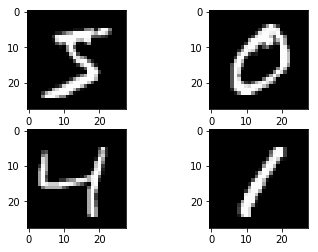

In [4]:
# Download the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# and let us look at the numbers
print("These are numbers corresponding to ",y_train[0]," ",y_train[1]," ",y_train[2]," and ",y_train[3])
plt.subplot(221)
plt.imshow(x_train[0], cmap=plt.get_cmap('gray'))
plt.subplot(222)
plt.imshow(x_train[1], cmap=plt.get_cmap('gray'))
plt.subplot(223)
plt.imshow(x_train[2], cmap=plt.get_cmap('gray'))
plt.subplot(224)
plt.imshow(x_train[3], cmap=plt.get_cmap('gray'))

In [5]:
# convert class vectors to binary class matrices
num_classes = 10
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

print("The cateragories of these image is now encoded as : \n",y_train[0][:],"\n",y_train[1][:],"\n",y_train[2][:],"\n",y_train[3][:],"\n" )

The cateragories of these image is now encoded as : 
 [ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.] 
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.] 
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.] 
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.] 



We shall **NOT** however, transform the images into one dimensional vectors. Instead, we want to keep them as two dimensional images. In fact, for keras and tensorflow to work correctly, we shall transform them from $28*28$ matrices to $28*28*1$ tensors! 

In [6]:
img_rows, img_cols = 28, 28
input_shape = (img_rows, img_cols, 1)
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

x_train.shape

(60000, 28, 28, 1)

## Creating a CNN

Now, we are going to create a convolutional network. The first two layers will each have $32$ convolutional filters of kernel size $3 \times 3$. Then we add a pooling layer that will take $2x2$ squares and output the max of them (the maxpooling layer) and transform the resulting "image" into a vector (the Flatten layer). Finally, we will add a multi-layer perceptron on top of this. With dropout layers, this yields:

In [9]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

model.compile(loss="categorical_crossentropy",
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 12, 12, 32)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               589952    
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)               0         
__________

Let's comment on the number of parameters and the output space in each layer, which will help to understand the structure of the layers.

- The first Conv2D layer has a kernel of size $3\times 3$, which has $3*3+1 = 10$ parameters (don't forget the bias!). There are 32 such filters, hence a total of $320$ parameters. Each filter is then applied independently to each region of the original image: there are $26\times 26$ regions, each outputs 32 filters, hence the output has shape $(26, 26, 32)$.

- The second Conv2D layer has also a kernel of size $3 \times 3$, but now it acts on a volume that has depth 32. Hence the number of parameters of each kernel is $3*3*32+1 = 289$. There are again 32 filters, leading to $289*32=9248$ parameters. Each filter is applied to one of the $24\times 24$ possible regions, hence the output shape is $(24, 24, 32)$.

- The max_pooling layer has no free parameters. It simply takes as output the maximum of the input in disjoint regions of size $2\times 2$, independently for each depth. The output is $(12, 12, 32)$.

- Finally, we apply a dropout and flatten, leading to a single vector of size $12*12*32=4608$, that we use as input for a MLP.

## Training the CNN

Let us finally train the problem. It will be, however, quite slow. Each epoch takes about $10$ seconds on high-end GPU such as NVIDIA $K80$, but take from one to three minutes on a standard computer/labtop.

In [10]:
batch_size = 128
epochs = 12

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 60000 samples, validate on 10000 samples
Epoch 1/12
60000/60000 [==============================] - 168s - loss: 0.3695 - acc: 0.8871 - val_loss: 0.0887 - val_acc: 0.9731
Epoch 2/12
60000/60000 [==============================] - 162s - loss: 0.1321 - acc: 0.9616 - val_loss: 0.0617 - val_acc: 0.9806
Epoch 3/12
60000/60000 [==============================] - 155s - loss: 0.1012 - acc: 0.9704 - val_loss: 0.0513 - val_acc: 0.9844
Epoch 4/12
60000/60000 [==============================] - 151s - loss: 0.0861 - acc: 0.9742 - val_loss: 0.0451 - val_acc: 0.9854
Epoch 5/12
60000/60000 [==============================] - 151s - loss: 0.0767 - acc: 0.9768 - val_loss: 0.0406 - val_acc: 0.9857
Epoch 6/12
60000/60000 [==============================] - 151s - loss: 0.0675 - acc: 0.9800 - val_loss: 0.0390 - val_acc: 0.9866
Epoch 7/12
60000/60000 [==============================] - 9935s - loss: 0.0621 - acc: 0.9817 - val_loss: 0.0370 - val_acc: 0.9871
Epoch 8/12
60000/60000 [======================

Still, the result is rewarding, without too much work, we reached an error below the percent! If you are patient (or you *DO* have a good GPU), you can try to play with the parameters and reach a performance close to $0.6\%$ error.